# **Detecção de Fraudes em Cartão de Crédito Utilizando Árvore de Decisão**




## Bibliotecas


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn import tree


## Análise exploratória dos dados



Baixamos o dataset e com o head vemos as 5 primeiras linhas  da nossa base de dados, sendo útil para visualizar os dados, colunas e entender seu conteúdo

In [ ]:
df = pd.read_csv('/content/fraud_detection_dataset.csv')

df.head()

,Transaction_ID,Customer_Name,Customer_Email,Transaction_Amount,Transaction_Date,Merchant_Name,Merchant_Email,Merchant_Location,Card_Number,Card_Expiry,Card_CVV,IP_Address,Device_Type,Transaction_Type,Fraudulent
0,2c276e09-24f7-4e6b-8122-47c3627a7268,Jennifer Wilson,amygreen@example.com,175.11,2024-03-01,Hampton-Powell,gregcaldwell@gillespie.net,Cayman Islands,4175618153978435573,06/30,777,42.103.253.55,Tablet,In-store,True
1,dc066519-15d4-45a6-9e6d-5333c0a55fbc,Scott Matthews,nicoleferguson@example.net,968.51,2024-02-23,Keller and Sons,deniseramsey@gallegos-hubbard.com,Zimbabwe,3513493835255325,09/24,632,156.41.109.8,Desktop,In-store,True
2,64d731f5-cd6f-4d7d-9a06-1c924f3cc26b,Melanie Franklin,fergusonmatthew@example.net,622.59,2024-02-28,"Pearson, Cooper and Miller",hlewis@moss.net,Mayotte,30164341270757,01/33,102,167.20.56.146,Desktop,Online,False
3,d65e7862-b30c-4df9-b44e-fd219c2429cb,Sabrina Waller,williamsshirley@example.com,698.31,2024-01-27,Mcdaniel and Sons,brianchavez@stevens.net,Antigua and Barbuda,30345609968469,12/26,902,52.241.35.223,Desktop,In-store,False
4,b355f6c7-04b9-4b52-958d-cce13114aafe,Lisa Blankenship,bondmitchell@example.org,86.73,2024-01-13,Richard-Russo,sandra12@mccall.com,Tanzania,4162499529947049565,01/25,849,135.255.117.111,Mobile,Online,True


Com o método .info() temos um resumo do DataFrame com quantidade de linhas ( 2000), quantidade de colunas (15), índice, tipo de dados de cada coluna e se ha números nulos ou não, nos fornecendo uma visão geral de sua estrutura.

Podemos notar que temos uma variável tipo Bool, 1 tipo float, 2 tipo int e 11 tipo objects.

Porém como nosso modelo será uma árvore de decisão e usaremos o Sklearn que não lida diretamente com variáveis categóricas é necessário converter para uma forma numérica antes de serem usadas no modelos de machine learning.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Transaction_ID      2000 non-null   object 
 1   Customer_Name       2000 non-null   object 
 2   Customer_Email      2000 non-null   object 
 3   Transaction_Amount  2000 non-null   float64
 4   Transaction_Date    2000 non-null   object 
 5   Merchant_Name       2000 non-null   object 
 6   Merchant_Email      2000 non-null   object 
 7   Merchant_Location   2000 non-null   object 
 8   Card_Number         2000 non-null   int64  
 9   Card_Expiry         2000 non-null   object 
 10  Card_CVV            2000 non-null   int64  
 11  IP_Address          2000 non-null   object 
 12  Device_Type         2000 non-null   object 
 13  Transaction_Type    2000 non-null   object 
 14  Fraudulent          2000 non-null   bool   
dtypes: bool(1), float64(1), int64(2), object(11)
memory usa

Na descrição do Dataframe podemos observar que na coluna de valor temos a menor transação de 10,69 e a maior de 999,59, tendo como mediana de 507,25. Observamos também que a maior parte das transções são de alto valor

In [ ]:
df.describe()

,Transaction_Amount,Card_Number,Card_CVV
count,2000.000000,2.000000e+03,2000.000000
mean,511.617505,3.631431e+17,864.213500
std,285.349648,1.222210e+18,1466.888507
min,10.690000,6.040139e+10,0.000000
25%,268.380000,1.447474e+14,283.000000
50%,507.255000,3.511683e+15,558.000000
75%,760.177500,4.659852e+15,814.000000
max,999.590000,4.998951e+18,9895.000000


Para avaliar se nosso modelo está balanceado foi efetuada a contagem da coluna Fraudulent, trazendo a informação da quantidade de True (1) que significa as transações fraudulentas e False(0) para transações legitimas. Para melhor visualização foi criado um gráfico de contagem (countplot) baseado nos dados do DataFrame sendo útil para visualizar rapidamente a distribuição de uma variável.

Com isso, foi possivel observar que a nossa base de dados esta balanceada não sendo necessário usar técnicas de balanceamento de classe.

In [ ]:
#Quantidade de fraude e de não fraude
contagem = df['Fraudulent'].value_counts()
contagem

Fraudulent
False    1003
True      997
Name: count, dtype: int64

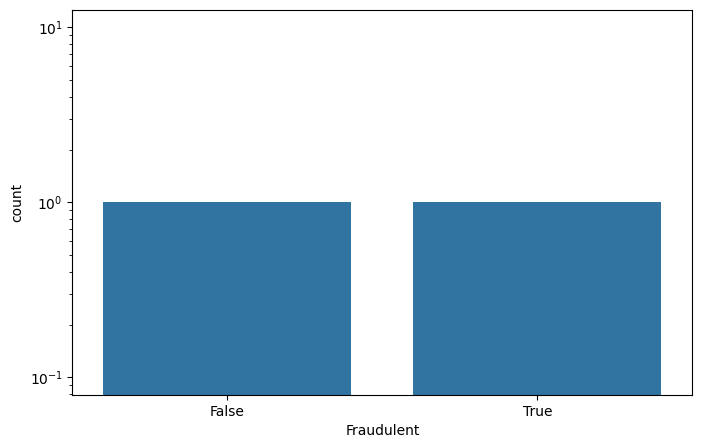

In [ ]:
plt.figure(figsize=(8,5))
_= sns.countplot(x='Fraudulent', data = df, log=True)
# Utilizando base logarítimica para melhor visualização

## Tratamento de dados

Após análise foi selecionado as melhores features para serem utilizadas. Essa seleção é de suma importância pois certas categorias podem não contribuir significativamente para a previsão.

In [ ]:
#retirando algumas colunas do DataFrame

df = df.drop(columns=['Transaction_ID', 'Transaction_Date'	, 'IP_Address',	'Customer_Email',	'Merchant_Email', 'Card_Expiry',	'Card_CVV',	'Device_Type', 'Card_Number'])

df.head()

,Customer_Name,Transaction_Amount,Merchant_Name,Merchant_Location,Transaction_Type,Fraudulent
0,Jennifer Wilson,175.11,Hampton-Powell,Cayman Islands,In-store,True
1,Scott Matthews,968.51,Keller and Sons,Zimbabwe,In-store,True
2,Melanie Franklin,622.59,"Pearson, Cooper and Miller",Mayotte,Online,False
3,Sabrina Waller,698.31,Mcdaniel and Sons,Antigua and Barbuda,In-store,False
4,Lisa Blankenship,86.73,Richard-Russo,Tanzania,Online,True


Como o modelo é uma árvore de decisão e será utilizada a biblioteca Sklear, foi utilizado o OrdinalEncoder da biblioteca scikit-learn para transformar variáveis categóricas em números ordinais.

In [ ]:
# Selecionar as colunas categóricas
categorical_features = ['Customer_Name', 'Merchant_Name', 'Transaction_Type', 'Merchant_Location']

# Inicializar o codificador ordinal
ordinal_encoder = OrdinalEncoder()

# Aplicar a codificação ordinal
df[categorical_features] = ordinal_encoder.fit_transform(df[categorical_features])

df

,Customer_Name,Transaction_Amount,Merchant_Name,Merchant_Location,Transaction_Type,Fraudulent
0,878.0,175.11,643.0,40.0,0.0,True
1,1715.0,968.51,867.0,242.0,0.0,True
2,1288.0,622.59,1277.0,137.0,1.0,False
3,1664.0,698.31,1050.0,8.0,0.0,False
4,1189.0,86.73,1389.0,214.0,1.0,True
...,...,...,...,...,...,...
1995,151.0,498.96,1473.0,85.0,1.0,False
1996,138.0,777.68,1301.0,88.0,0.0,True
1997,693.0,930.97,130.0,219.0,0.0,True
1998,1309.0,250.43,1637.0,16.0,1.0,False


In [ ]:
# Convertendo valores booleanos para inteiros (0 para False, 1 para True)
df['Fraudulent'] = df['Fraudulent'].astype(int)

df

,Customer_Name,Transaction_Amount,Merchant_Name,Merchant_Location,Transaction_Type,Fraudulent
0,878.0,175.11,643.0,40.0,0.0,1
1,1715.0,968.51,867.0,242.0,0.0,1
2,1288.0,622.59,1277.0,137.0,1.0,0
3,1664.0,698.31,1050.0,8.0,0.0,0
4,1189.0,86.73,1389.0,214.0,1.0,1
...,...,...,...,...,...,...
1995,151.0,498.96,1473.0,85.0,1.0,0
1996,138.0,777.68,1301.0,88.0,0.0,1
1997,693.0,930.97,130.0,219.0,0.0,1
1998,1309.0,250.43,1637.0,16.0,1.0,0


## Divisão dos Dados em Treino e Teste





Para que seja possivel  avaliar quão bem o modelo será capaz de fazer previsões precisas é necessário a divisão dos dados em treino e teste.,
O x são as features do conjunto de dados, excluindo a coluna 'Fraudulent'
O y é a variável alvo, 'Fraudulent'

In [ ]:
# Dividir os dados em features (x) e target (y)
x = df.drop('Fraudulent', axis=1).values
y = df['Fraudulent'].values


In [ ]:
# Dividir os dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0)

## Execução do Classificador



A execução do classificador refere-se ao uso do modelo treinado para fazer previsões ou classificações nos dados de teste, utilizando as regras aprendidas durante o treino

In [ ]:
def executar_classificador(classificador, x_train, x_test, y_train):
  arvore = classificador.fit(x_train, y_train)
  y_pred = arvore.predict(x_test)
  return y_pred

In [ ]:
# execução do classificador
classificador_arvore_decisao = tree.DecisionTreeClassifier(max_depth=7, random_state=30)
y_pred_arvore_decisao = executar_classificador(classificador_arvore_decisao, x_train, x_test, y_train)

## Plotagem da Árvore


In [ ]:
def salvar_arvore(classificador, nome):
  plt.figure(figsize=(40, 20))
  tree.plot_tree(classificador, filled=True, fontsize=14)
  plt.savefig(nome)
  plt.close()

In [ ]:
# Salvar árvore de decisão como imagem
salvar_arvore(classificador_arvore_decisao, "arvore_decisao.png")

## Avaliação do Desempenho da Árvore de Decisão




A avaliação do desempenho do modelo é necessária para entender quão bem o modelo está realizando sua tarefa de classificação ou regressão. Sendo crucial para determinar a eficácia do modelo e para identificar possíveis pontos de melhoria.
Para avaliação foi utilizada a acurácia que é uma métrica que indica a taxa de acerto do modelo, a precisão que mede a quantidade de verdadeiros e falsos positivos, o recall que trás com base no total que ele poderia classificar como positivo, quantas ele acertou e a matriz de confusão que é a razão entre verdadeiros positivos e falsos positivos.

In [ ]:
def validar_arvore(y_pred, y_test):
  print("Acurácia:", accuracy_score(y_pred, y_test))
  print("Precisão:", precision_score(y_pred, y_test))
  print("Matriz de Confusão:", confusion_matrix(y_pred, y_test))
  print("Recall:", recall_score(y_pred, y_test))

In [ ]:
# Validação do desempenho da árvore de decisão
print("Desempenho da Árvore de Decisão:")
validar_arvore(y_pred_arvore_decisao, y_test)

Desempenho da Árvore de Decisão:
Acurácia: 0.50125
Precisão: 0.8575129533678757
Matriz de Confusão: [[ 70  55]
 [344 331]]
Recall: 0.49037037037037035


## Como melhorar o desempenho do modelo

Ter uma base de dados Robusta é de suma importancia para obter um bom resultado de desempenho no modelo.

Alguns dados são impreencidiveis para se ter uma acurácia maior em uma árvore de decisão para detecção de fraudes em cartão de crédito, como nome do cliente, nome do estabelecimento, tipo da transação (se foi online ou presencial e se presencial se ocorreu por aproximação ou com chip e inseriu a senha ou não) , valor da transação, localidade do cliente e do estabelecimento onde a compra foi efetivada, histórico de transação do cliente que revelam padrões de uso como horários típicos de compras, tipos de estabelecimentos frequentados, médiana dos valores de compra, dados Temporais como horário da transação, dias da semana ou periodos do ano que revelam padrões de compra sazonais ou específicos, informações sobre transações anteriores que foram marcadas como fraudulentas ou legítimas e Informações Contextuais Externas, como alertas de segurança de terceiros, padrões de fraude em outras instituições financeiras, notícias sobre novas técnicas de fraude, podem ser integradas para melhorar a precisão do modelo.

Outro técnica a se considerar é o Random Forests (florestas aleatórias) pois geralmente melhoram a precisão ao combinar múltiplas árvores de decisão.









